In [130]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature, draw, transform
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import math
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Hough Transform with point clouds, output is the centers and the related 2d image/edges 

Note: This Hough transform is connected with below mask segmentation, so the number of points before and after projection should be very close, circle radius is also measured in such context.

When J.S wrote the code, the projected image width = range_x * 1000(approximate 740), the radius under this proportion is 26-27. and the min_distance(distance between circle center) I chose was 30. This need to be adjusted in proportional with the image width in accordance to your input.

In [131]:
def Hough_Circle_Centers(points):
    
    
    #project to 2D 
    projected_points = points[:, :2]
    print('the number of 3D projected points are : ', len(projected_points))
    
#Getting x,y maximum and minimum  
    min_vals = np.min(projected_points, axis=0)
    print("min_vals is : ",min_vals)
    max_vals = np.max(projected_points, axis=0)
    print("max_vals is : ", max_vals)

    range_x = max_vals[0] - min_vals[0]
    range_y = max_vals[1] - min_vals[1]

    #Calculate number of points on X and on Y in 2D projection image
    num_of_points_on_x = range_x*1000#np.ceil(range_x/0.0004)
    num_of_points_on_y = range_y*1000 #np.ceil(range_y/0.0004)
    
    
    print('num_of_points_on_x is : ', num_of_points_on_x)
    print('num_of_points_on_y is : ', num_of_points_on_y)

    #Initialize the 2D image for projection

    image_width = int(num_of_points_on_x) 
    image_height = int(num_of_points_on_y)


    print('image_width is : ', image_width)
    print('image_height is: ', image_height)
    
    image_size = (image_height, image_width)
    image = np.zeros(image_size, dtype=np.uint8)


    
    projected_points_num = 0
    for point in projected_points:
    # Map coordinates to image space (normalize the points to the image size)
        x = int((point[0] - min_vals[0]) / range_x * (image_width - 1))  # Map to x-axis (horizontal)
        y = int((point[1] - min_vals[1]) / range_y * (image_height - 1))  # Map to y-axis (vertical)
        
        projected_points_num = projected_points_num+1
        
        image[y, x] = 255
    
    print('the number of 2D image points are : ', projected_points_num)
      
    
    #（range_x * 1000） is the previous image width Jessica used
    
    #min_distance = 30/(range_x * 1000) * image_width # defines the distance between circle centers
    min_distance = 30
    print('min_distance is : ', min_distance)
    
    
    
    edges = feature.canny(image, sigma=2)
    
    #radius_lower = 26/(range_x * 1000) * image_width
    #print('radius_lower is : ', radius_lower)
    #radius_higher = 27/(range_x * 1000) * image_width
    #print('radius_higher is : ', radius_higher)
    
    hough_radii = np.arange(26, 27, 1)  
    hough_res = transform.hough_circle(edges, hough_radii)

    accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii, num_peaks=500)



    centers = np.stack((cx, cy,radii), axis=1)  # Stacks center coordinates along the second dimension
    #print('centers: ', centers)
    #print('centers shape is  ', centers.shape)
    
    #sort the circle centers
    centers = centers[centers[:, 1].argsort()]
    
    # filter and remove multiple response on 1 circle
    filtered_centers = []
    filtered_radii=[]

    for center in centers:
        if all(np.linalg.norm(center[0:2] - np.array(c[0:2])) >= min_distance for c in filtered_centers):
            filtered_centers.append(center[0:2])
            filtered_radii.append(center[2])
            
    filtered_centers = np.array(filtered_centers)  # Convert back to a NumPy array
    filtered_radii = np.array(filtered_radii)
    
    print('filtered_centers shape is : ', filtered_centers.shape)
    
    
        #visualize the edges, if needed

    # Create a figure for a single plot
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size as needed

    # Plot the binary image
    ax.imshow(edges, cmap='gray', extent=(0, edges.shape[1], edges.shape[0], 0))  # Map pixel dimensions with `extent`
    ax.set_title("Binary Image")  # Title of the plot
    ax.set_xlabel("X Distance (pixels)")  # Label for the x-axis
    ax.set_ylabel("Y Distance (pixels)")  # Label for the y-axis
    ax.axis('on')  # Ensure the axis is visible

    # Add ticks to represent pixel units
    ax.set_xticks(range(0, edges.shape[1] + 1, edges.shape[1] // 10))  # Divide into 10 intervals
    ax.set_yticks(range(0, edges.shape[0] + 1, edges.shape[0] // 10))  # Divide into 10 intervals

    # Display the plot
    plt.tight_layout()
    plt.show()
    
    output_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    # in connected with visualizing the centers
    #for i in range(len(neighbors)):
    #    output_image[neighbors[i][1],neighbors[i][0]] = [255,255,255]

    centers = centers.astype(int)
    radii = radii.astype(int)
    for center_x, center_y, radius in zip(centers[:,0], centers[:,1], radii):
        circy, circx = draw.circle_perimeter(center_y, center_x, radius, shape=image.shape)
    
        # Ensure the circle coordinates are within bounds of the image
        valid = (circx >= 0) & (circx < output_image.shape[1]) & (circy >= 0) & (circy < output_image.shape[0])
        circx, circy = circx[valid], circy[valid]
    
        # Assign the color (e.g., red) to each pixel on the circle perimeter
        output_image[circy, circx] = [255, 0, 0]
    
        # Create a figure for a single plot
    fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed

    # Display the image with detected circles
    ax.imshow(output_image, cmap='gray')  # Show the output image
    ax.set_title("Detected Circles (Hough Transform)")  # Title for the image
    ax.axis('off')  # Hide the axes for a cleaner look

    # Display the plot
    plt.tight_layout()
    plt.show()



    

    return filtered_centers,filtered_radii, image, edges, max_vals, min_vals


the number of 3D projected points are :  16448
min_vals is :  [-0.3720845  0.1805014]
max_vals is :  [0.38358468 0.26608473]
num_of_points_on_x is :  755.6691765785217
num_of_points_on_y is :  85.58332920074463
image_width is :  755
image_height is:  85
the number of 2D image points are :  16448
min_distance is :  30
filtered_centers shape is :  (8, 2)


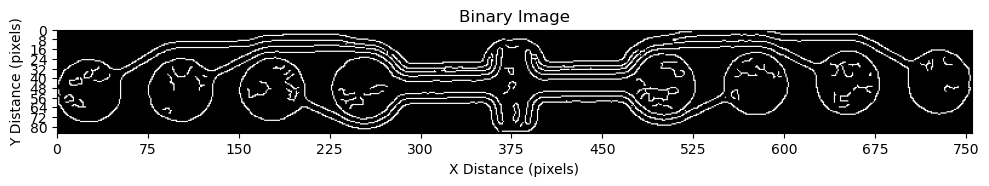

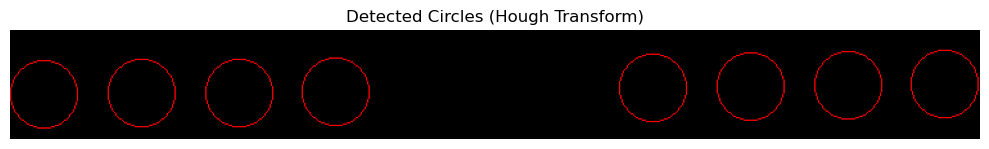

In [132]:
#reading in mask
pcd = o3d.io.read_point_cloud('/Users/pmmac/Desktop/pipe_mask/black1.ply')
points = np.asarray(pcd.points)
centers,radii,image,edges, max_vals, min_vals = Hough_Circle_Centers(points)

In [133]:
centers

array([[727,  42],
       [652,  43],
       [576,  44],
       [500,  45],
       [253,  48],
       [102,  49],
       [178,  49],
       [ 26,  50]])

# Align Pivots(utilizing Hough centers to output image center and rotation degree)

In [134]:
def Align_Pivots_from_Centers(centers, radii, image, edges, max_vals, min_vals):

    #select the 8 centers of the first row
    formlinepoints = centers[0:8]
    #print('formlinepoints is : ', formlinepoints)
    point1 = centers[0]
    point2 = centers[7]

    x = [point1[0], point2[0]] 
    y = [point1[1], point2[1]]

#acquire the slope and bias term for the interpolated line
    coefficients = np.polyfit(x, y, 1)

    #To draw the graph of the line in below code
    '''
    # Print the findings
    print('a =', coefficients[0])
    print('b =', coefficients[1])

    # Let's compute the values of the line...
    polynomial = np.poly1d(coefficients)
    x_axis = np.linspace(0,500,100)
    y_axis = polynomial(x_axis)

    # ...and plot the points and the line
    plt.plot(x_axis, y_axis)
    plt.plot( x[0], y[0], 'go' )
    plt.plot( x[1], y[1], 'go' )
    plt.grid('on')
    plt.show()
    
    '''
        
    #getting the rotation degree for the chip
    degree = np.arctan(coefficients[0])
    #print('degree is : ', degree)

    def get_ordered_list(points, x, y):
        distances = (points[:, 0] - x)**2 + (points[:, 1] - y)**2
        sorted_indices = np.argsort(distances)
        return points[sorted_indices]
    
    image_width = image.shape[1]
    image_height = image.shape[0]
    #acquire current "averaged" center
    psedo_center = [image_width/2,image_height/2]
    print('psedo center is : ' , psedo_center)
    
    #calculate all the centers' distance to the "averaged" center point and sort in descending order
    psedo_center_list = get_ordered_list(centers, psedo_center[0], psedo_center[1])
    #print('psedo_center_list is : ', psedo_center_list)
    
    
    if image_height < 100: # if we're aligning the mask
        #acquire the 2 circle centers in the mask center
        pivot_centers = psedo_center_list[0:2]
    else:   
        #acquire the 4 circle centers in the center area
        pivot_centers = psedo_center_list[0:4]
        print('pivot_centers are : ', pivot_centers)

  

    #getting the actual center by averaging the 4 centers
    precise_center = np.mean(pivot_centers, axis=0)
    precise_center = np.ceil(precise_center) # note this might be better with floor, not ceil
    #print('precise center after round up is : ', precise_center)

    #convert to int for indexing
    precise_center = precise_center.astype(int)
    print('precise_center is : ', precise_center)
    #print('image size is : ', image_size)


    #if you want to visualize in the 2D image the actual center(by setting 8 neighbors as 255),
    #unquote below
    '''
    def get_neighbors(point):
        x, y = point
        # Generate all 8 neighbors
        neighbors = [
            (x - 1, y - 1),  # Top-left
            (x, y - 1),      # Top
            (x + 1, y - 1),  # Top-right
            (x - 1, y),      # Left
            (x + 1, y),      # Right
            (x - 1, y + 1),  # Bottom-left
            (x, y + 1),      # Bottom
            (x + 1, y + 1)   # Bottom-right
            ]
        return neighbors

    # Example usage
    point = (420, 652)
    neighbors = get_neighbors(point)

    print('neighbors are : ', neighbors)
    print("neighbors type is : ", type(neighbors))
    '''
 
    
    range_x = max_vals[0] - min_vals[0]
    range_y = max_vals[1] - min_vals[1]
    
    
    # project the 2D center back to 3D 
    precise_x_3d = precise_center[0] / (image_width - 1) * range_x + min_vals[0]
    precise_y_3d = precise_center[1] / (image_height - 1) * range_y + min_vals[1]

    centerin3d = [precise_x_3d,precise_y_3d]

    print('centerin3d is : ', centerin3d)
    print('rotation degree is : ', degree)



    # Original Code by Jessica, reserved in case of need
    
    # Plot the original and result images side-by-side



    # Back-project 2D circle detections to 3D
    #filtered_points = []
    #filtered_colors = []

    # Back-project 2D circle detections to 3D
    #original_colors = np.asarray(pcd.colors)
   
    return centerin3d, degree

In [136]:
centerin3d, degree = Align_Pivots_from_Centers(centers, radii, image, edges, max_vals, min_vals)

psedo center is :  [377.5, 42.5]
precise_center is :  [377  47]
centerin3d is :  [0.005750089883804321, 0.2283873118105389]
rotation degree is :  -0.011411772782924589


# Alignment (center align and rotation)

In [137]:
def Alignment(pcd):

    points = np.asarray(pcd.points)
    centers, radii, image, edges, max_vals, min_vals = Hough_Circle_Centers(points)
    

    centerin3d, degree = Align_Pivots_from_Centers(centers, radii, image, edges, max_vals, min_vals)    
    print(degree)
    #inlier_cloud = o3d.io.read_point_cloud('/Users/pmmac/Desktop/OneDrive_1_2024-10-22/DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01/2024-09-02_130544_243301-11/raw/tray-b-4-a_L2_part_1_downsample_10_without_ears.ply')
    # Create a coordinate frame (axis)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

    # Visualize the point cloud with the coordinate frame
    o3d.visualization.draw_geometries([pcd, axis], window_name="Point Cloud with Axis")



    rotation_center = np.array([centerin3d[0], centerin3d[1], 0])

    #degree = np.pi / 4*3 #example, 135 degree
    # Define the rotation angle (in radians)
    angle = -degree  

    # Step 1: Translate the point cloud to center the rotation point at the origin
    translation_to_origin = -rotation_center
    pcd.translate(translation_to_origin)

    # Step 2: Create the rotation matrix for rotation around the Z-axis
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0,              0,             1]
    ])

    # Apply the rotation matrix
    pcd.rotate(rotation_matrix, center=(0, 0, 0))  # Rotate around the origin

    
    # Create a coordinate frame (axis)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1, origin=[0, 0, 0])

    # Visualize the point cloud with the coordinate frame
    o3d.visualization.draw_geometries([pcd, axis], window_name="Point Cloud with Axis")
    
    return pcd

# Align a 3D mask 

the number of 3D projected points are :  16448
min_vals is :  [-0.3720845  0.1805014]
max_vals is :  [0.38358468 0.26608473]
num_of_points_on_x is :  755.6691765785217
num_of_points_on_y is :  85.58332920074463
image_width is :  755
image_height is:  85
the number of 2D image points are :  16448
min_distance is :  30
filtered_centers shape is :  (8, 2)


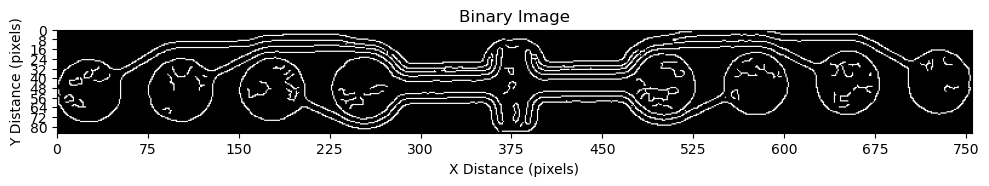

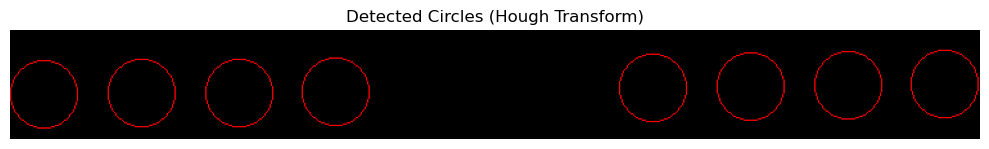

psedo center is :  [377.5, 42.5]
precise_center is :  [377  47]
centerin3d is :  [0.005750089883804321, 0.2283873118105389]
rotation degree is :  -0.011411772782924589
-0.011411772782924589
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [138]:
aligned_mask = Alignment(pcd)

# Align pipes

the number of 3D projected points are :  264158
min_vals is :  [-0.38084566 -0.60603926]
max_vals is :  [0.38548825 0.62197137]
num_of_points_on_x is :  766.3339120492367
num_of_points_on_y is :  1228.0106353984195
image_width is :  766
image_height is:  1228
the number of 2D image points are :  264158
min_distance is :  30
filtered_centers shape is :  (128, 2)


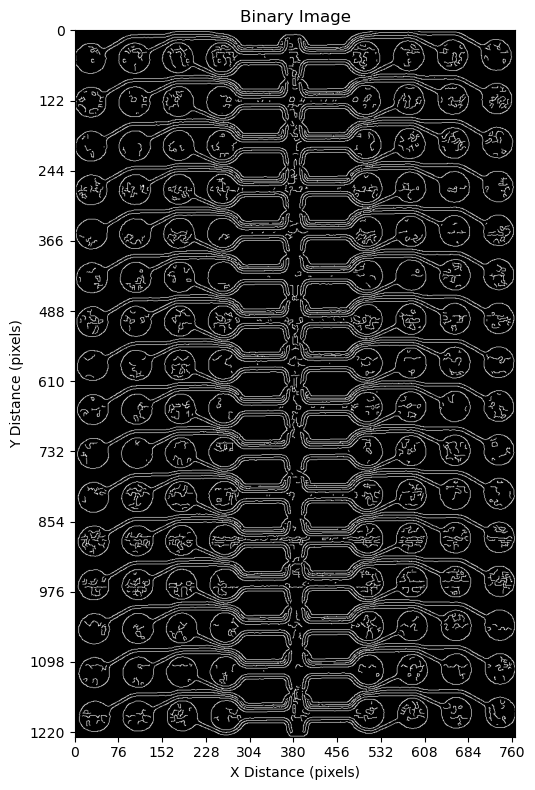

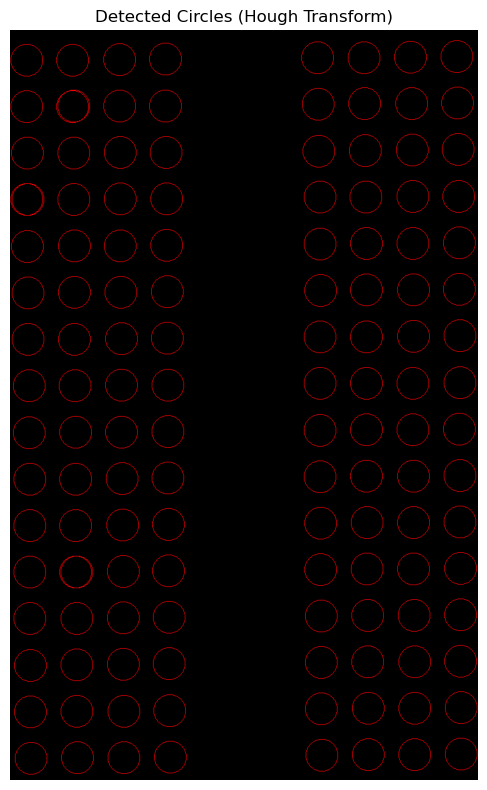

psedo center is :  [383.0, 614.0]
pivot_centers are :  [[507 578]
 [258 581]
 [507 655]
 [258 657]]
precise_center is :  [383 618]
centerin3d is :  [0.0028221665006432084, 0.012469763763789943]
rotation degree is :  -0.009538661409814334
-0.009538661409814334
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [139]:
pcd2 = o3d.io.read_point_cloud('/Users/pmmac/Desktop/OneDrive_1_2024-10-22/DATA_3F_DOWNSAMPLED10_WITHOUT_EARS_e0_01_SEGMENTED/2024-09-02_130544_243301-11/raw/tray-b-4-a_L2_part_1_downsample_10_without_ears_seg_pipes.ply')
pcd2 = Alignment(pcd2)
#o3d.visualization.draw_geometries([pcd])

#write out aligned mask
#o3d.io.write_point_cloud('/Users/pmmac/Desktop/pipe_mask/aligned_black1.ply', pcd)

# Project and dilate the mask

the number of 3D projected points are :  16448
min_vals is :  [-0.37787246 -0.04582501]
max_vals is :  [0.3778282  0.03759766]
num_of_points_on_x is :  755.7006659964438
num_of_points_on_y is :  83.42266895967396
image_width is :  755
image_height is:  83
the number of 2D image points are :  16448
min_distance is :  30
filtered_centers shape is :  (8, 2)


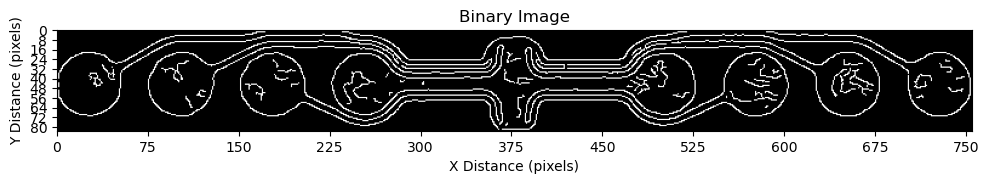

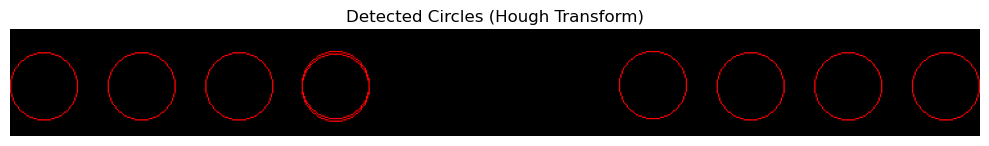

In [140]:
mask_points = np.asarray(aligned_mask.points)
centers,radii,image,edges, max_vals, min_vals = Hough_Circle_Centers(mask_points)

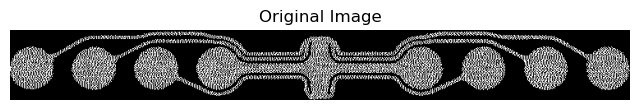

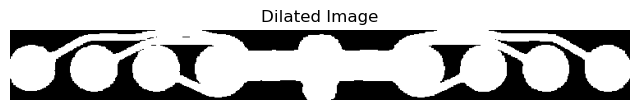

True

In [141]:
mask_points = np.asarray(aligned_mask.points)
projected_points = mask_points[:,:2]


min_vals = np.min(projected_points, axis=0)
max_vals = np.max(projected_points, axis=0)


image_height = image.shape[0]
image_width = image.shape[1]

image_size = (image_height, image_width)
image = np.zeros(image_size, dtype=np.uint8)

range_x = max_vals[0] - min_vals[0]
range_y = max_vals[1] - min_vals[1]

for point in projected_points:
    # Map coordinates to image space (normalize the points to the image size)
    x = int((point[0] - min_vals[0]) / range_x * (image_width - 1))  # Map to x-axis (horizontal)
    y = int((point[1] - min_vals[1]) / range_y * (image_height - 1))  # Map to y-axis (vertical)

    image[y, x] = 255

    

    
#image_plus = np.zeros((image_height+2, image_width), dtype=np.uint8)
#image_plus[2:,:] = image

# Define the structuring element (kernel) for dilation
kernel = np.ones((5, 5), np.uint8)  # 5x5 square kernel

#add 2 rows of 0 on the top and remove 2 rows on bottom(2D display)
#modified_image = np.zeros((image.shape[0] + 2, image.shape[1]), dtype=image.dtype)

# Insert the original image content (excluding the last 2 rows)
#modified_image[2:-2, :] = image[:-2, :]



# Apply dilation
dilated_image = cv2.dilate(image_plus, kernel, iterations=1)

#dilated_image = dilated_image[:-2,:]

# Display the first image in its own window
plt.figure("Original Image", figsize=(8, 6))  # Set the window title and size
plt.title("Original Image")
plt.imshow(image_plus, cmap='gray')  # Display the original image
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()

# Display the second image in a separate window
plt.figure("Dilated Image", figsize=(8, 6))  # Set the window title and size
plt.title("Dilated Image")
plt.imshow(dilated_image, cmap='gray')  # Display the dilated image
plt.axis('off')  # Hide the axes for a cleaner look
plt.show()


cv2.imwrite('/Users/pmmac/Desktop/pipe_mask/dilated_mask.png', dilated_image)





In [126]:
dilated_image.shape

(85, 755)

In [127]:
image_plus.shape

(85, 755)

# Segment 1 unit pipe with mask

In [142]:
def project_back_to_2D(point, imageshape, max_vals, min_vals):
        
        range_x = max_vals[0] - min_vals[0]
        range_y = max_vals[1] - min_vals[1]
        image_width = imageshape[1]
        image_height = imageshape[0]
        
        
        
        #x = point[0] / (image_width - 1) * range_x + min_vals[0]
        #y = point[1] / (image_height - 1) * range_y + min_vals[1]

        x = int((point[0] - min_vals[0]) / range_x * (image_width - 1))  # Map to x-axis (horizontal)
        y = int((point[1] - min_vals[1]) / range_y * (image_height - 1))  # Map to y-axis (vertical)
        
        return [x,y]

the number of 3D projected points are :  264158
min_vals is :  [-0.38155865 -0.6173028 ]
max_vals is :  [0.38183321 0.60948932]
num_of_points_on_x is :  763.3918531500159
num_of_points_on_y is :  1226.792116263324
image_width is :  763
image_height is:  1226
the number of 2D image points are :  264158
min_distance is :  30
filtered_centers shape is :  (128, 2)


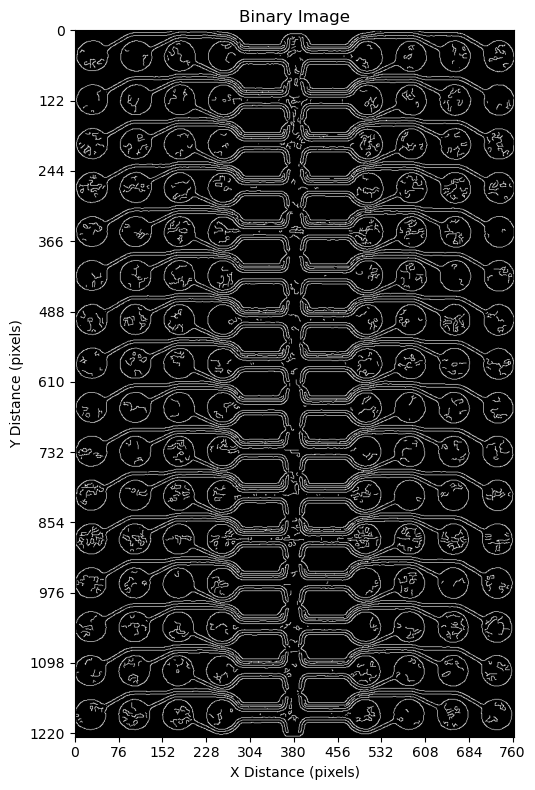

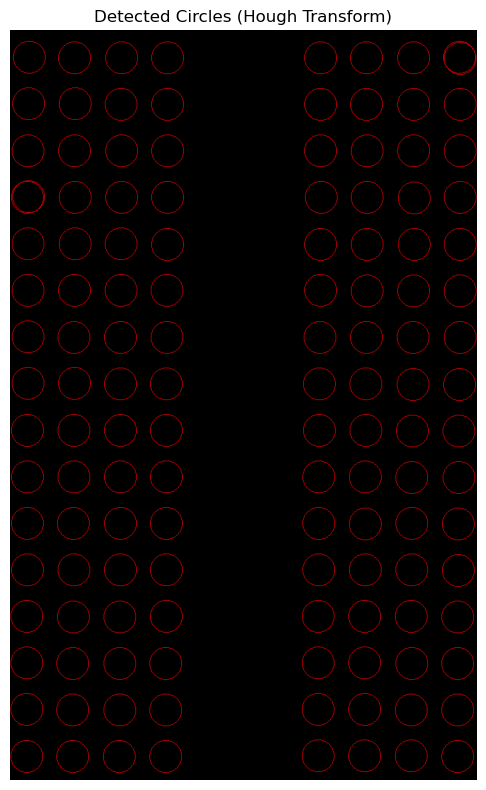

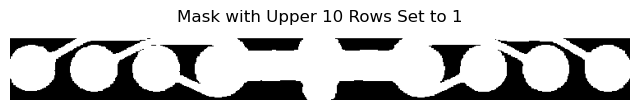

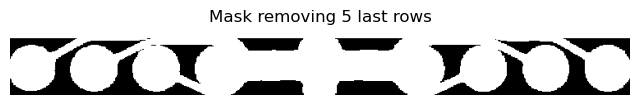

mask shape after down 30 rows :  (109, 755)


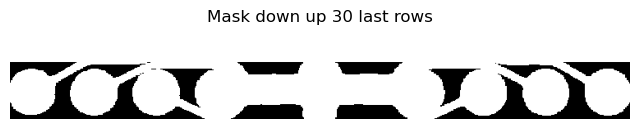

updated mask center :  [347.5, 42.5]
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


True

In [146]:
#Continue with the aligned pipes
points = np.asarray(pcd2.points)

#acquire the projected 2D image,projected max and min value of  and first 8 centers of 
#the pointcloud for projection 
centers,_, image_full, _,max_vals,min_vals = Hough_Circle_Centers(points)
center_of_row1 = np.mean(centers[0:8],axis = 0)

# Read in mask
mask = cv2.imread('/Users/pmmac/Desktop/pipe_mask/dilated_mask.png', cv2.IMREAD_GRAYSCALE)

#initialize a blanck set for points record
selected_points = []

#acquire the mask center for projection shift, have to do it now for correspondance!
maskcenter = [mask.shape[1]/2, mask.shape[0]/2] 


#print("initial mask center : ", maskcenter)
#extend the mask for 3 row towards the bottom
#row_of_ones = np.ones((3, mask.shape[1]), dtype=mask.dtype) *255
#mask = np.vstack((row_of_ones,mask))
'''
mask[:10, :] = 255


plt.figure(figsize=(8, 6))
plt.title("Mask with Upper 10 Rows Set to 1")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

mask = mask[:-6,:]


plt.figure(figsize=(8, 6))
plt.title("Mask removing 5 last rows")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()


row_of_ones = np.ones((30, mask.shape[1]), dtype=mask.dtype) *255
mask = np.vstack((row_of_ones,mask))


print('mask shape after down 30 rows : ', mask.shape)

plt.figure(figsize=(8, 12))
plt.title("Mask down up 30 last rows")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

#moving down 30 rows will result in center shifting for 30 rows as well
maskcenter[0] = maskcenter[0]-30
print("updated mask center : ", maskcenter)
'''

for point in points:
    # Project the point back to 2D
    point_2d = project_back_to_2D(point,image_full.shape, max_vals, min_vals)
    
    #print(point_2d)
    # Adjust by the center of the first row
    point_2d = point_2d - center_of_row1 + maskcenter
    #print(point_2d)
    
    #print(image_full[0])
    #print(image_full[1])
    # Check if the point is within the image boundaries
    

    if (0 <= point_2d[1] <= mask.shape[0]) and (0 <= point_2d[0] <= mask.shape[1]):
        # Ceil the 2D point coordinates
        point_2d_up = np.ceil(point_2d).astype(int)  # Ensure point_2d is integer for indexing
        point_2d_down = np.floor(point_2d).astype(int)
        # Check if the mask image at the point has the specified value
        if (mask[point_2d_up[1]-1, point_2d_up[0]-1] == [255, 255]).all():
            selected_points.append(point)
        
        if (mask[point_2d_down[1]-1, point_2d_down[0]-1] == [255, 255]).all():
            selected_points.append(point)
            
            

#print('selected_points are : ', selected_points)

selected_points = np.unique(selected_points, axis=0)
selected_points= np.array(selected_points)

s_pcd = o3d.geometry.PointCloud()
s_pcd.points = o3d.utility.Vector3dVector(selected_points)
o3d.visualization.draw_geometries([s_pcd])

o3d.io.write_point_cloud('/Users/pmmac/Desktop/unit_pipe1+++.ply', s_pcd)

# Recursive Segmentation for 1 chip Using Dilated mask

# Segment the rolls in 3d Pcd wrote by Jessica Strom

In [70]:
for i, (x, y, r) in enumerate(zip(cx, cy, radii)):
    # Convert image coordinates back to 2D space
    x_world = x / (image_width - 1) * range_x + min_vals[0]
    y_world = y / (image_height - 1) * range_y + min_vals[1]
    radius_world = r / (image_width - 1) * range_x  # Assume uniform scaling

    # Find 3D points within the circle's projected radius
    distances = np.linalg.norm(projected_points - np.array([x_world, y_world]), axis=1)
    mask = distances <= radius_world
    circle_points = points[mask]
    circle_colors = original_colors[mask]

    # Compute the centroid of the circle
    centroid = np.mean(circle_points, axis=0)

    # Center the circle by subtracting the centroid
    centered_points = circle_points - centroid

    # Create a point cloud for this circle
    circle_cloud = o3d.geometry.PointCloud()
    circle_cloud.points = o3d.utility.Vector3dVector(centered_points)
    circle_cloud.colors = o3d.utility.Vector3dVector(circle_colors)

    # Save the circle as a separate file
    filename = f"2024-09-02_155419_243301-12_tray-b-4-a_L2_part_1_downsample_10_without_ears_seg_pipes{i+1}.ply"
    #o3d.io.write_point_cloud(filename, circle_cloud)

    #print(f"Saved circle {i+1} to {circle_cloud}")






In [41]:
def project_back_to_3D(point, imageshape, max_vals, min_vals):
    
    range_x = max_vals[0] - min_vals[0]
    range_y = max_vals[1] - min_vals[1]
    image_width = imageshape[1]
    image_height = imageshape[0]
    # project the 2D center back to 3D 
    point_3d_x = point[0] / (image_width - 1) * range_x + min_vals[0]
    point_3d_y = point[1] / (image_height - 1) * range_y + min_vals[1]
    
    point_3d = [point_3d_x, point_3d_y]
    return point_3d

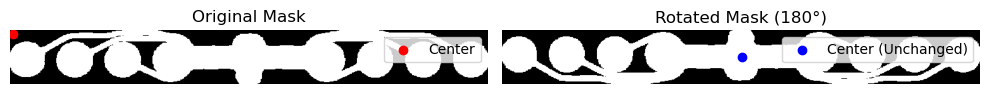

In [72]:
import numpy as np

def rotate_180(mask, original_center):
    """
    Rotates a 2D mask by 180 degrees and keeps track of the center point.

    Parameters:
    - mask (numpy.ndarray): The 2D binary mask to be rotated.
    - original_center (list or tuple): The original center coordinates [x, y].

    Returns:
    - rotated_mask (numpy.ndarray): The 180-degree rotated mask.
    - new_center (list): Center coordinates after rotation (unchanged for 180 degrees).
    """
    # Rotate the mask by 180 degrees (equivalent to flipping both axes)
    rotated_mask = np.rot90(mask, 2)

    # For a 180-degree rotation, the center point stays the same
    new_center = list(original_center)  # Center remains unchanged

    return rotated_mask, new_center

# Example usage
# Create a simple 10x10 binary mask with a center

mask = cv2.imread('/Users/pmmac/Desktop/pipe_mask/dilated_mask.png', cv2.IMREAD_GRAYSCALE)
maskcenter = [mask.shape[1]/2, mask.shape[0]/2] 



# Rotate the mask by 180 degrees
rotated_mask, new_center = rotate_180(mask, maskcenter)

# Display the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Original mask
plt.subplot(1, 2, 1)
plt.title("Original Mask")
plt.imshow(mask, cmap='gray')
plt.scatter(*original_center, color='red', label='Center')
plt.legend()
plt.axis('off')

# Rotated mask
plt.subplot(1, 2, 2)
plt.title("Rotated Mask (180°)")
plt.imshow(rotated_mask, cmap='gray')
plt.scatter(*new_center, color='blue', label='Center (Unchanged)')
plt.legend()
plt.axis('off')

plt.tight_layout()
plt.show()

